# Legacy Reconstruction

This example shows the implementation in **cloudy** of the differentiable methods for multiple-scattering in a medium (Differentiable Ratio-tracking and Singular Path-sampling). Those methods can be used in a multi-resolution scheme (from coarse to detailed) to reconstruct a volume. Even adding smoothness or sparsity priors, the volume suffers from ambiguities if too few views are used.

In [1]:
try:  # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's initialize everything similarly to tutorial 05 (sparse view).
> Notice the argument `mode` in `scattered` function. sps will use Singular Path-sampling while drt will use Differentiable Ratio-tracking. 

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loading cached reference_image3.pt


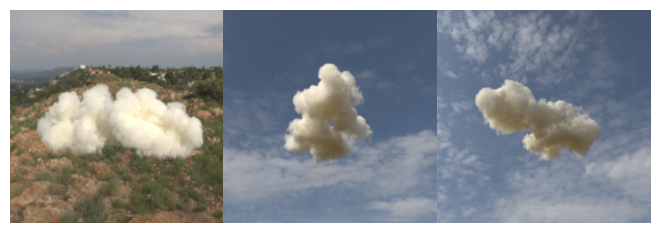

In [2]:
import cloudy
import torch
import numpy as np
import vulky.datasets as datasets  # module containing some resources for examples.
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()  # Comment if it is already downloaded
ref_latent = pipeline.get_test_latent(8)
ref_grid = pipeline.decode_latent(ref_latent)
ref_grid = pipeline.clean_volume(ref_grid)

settings = dict(
    camera_positions = [
        [np.cos(0.5) * 2.7, np.sin(0.5), np.sin(0.5) * 2.7],
        [np.cos(0.5 + 1) * 2.7, -2.0, np.sin(0.5 + 1) * 2.7],
        [np.cos(0.5 + 2) * 2.7, -2.0, np.sin(0.5 + 2) * 2.7]
    ],
    environment = datasets.Images.environment_example.to('cuda'),  # An HDR environment
    density_scale = 300,
    phase_g = 0.0,
    scattering_albedo = (0.99, 0.98, 0.94),
)
environment, environment_sampler = cloudy.environment_objects(settings['environment'])


def render_grid(g: torch.Tensor, samples: int = 128):
    camera_poses = cloudy.camera_poses(
        origins=torch.tensor(settings['camera_positions'], dtype=torch.float32)
    )
    return cloudy.scattered(g * settings['density_scale'],
                     camera_poses=camera_poses,
                     scattering_albedo=settings['scattering_albedo'],
                     environment=environment,
                     environment_sampler=environment_sampler,
                     phase_g=settings['phase_g'],
                     majorant=g.max() * settings['density_scale'],
                     # kwargs
                     width=512,  # image width in pixels
                     height=512,  # image height in pixels
                     jittered=True,  # rays pass through 
                     samples=samples,  # number of ray paths for the primal evaluation
                     samples_bw=8,  # number of ray paths for the gradients backprop
                     mode='sps'  # singular path-sampling is used instead of DRT.
                     )


with torch.no_grad():
    # Generate reference image
    if os.path.exists('./reference_image3.pt'):
        print("Loading cached reference_image3.pt")
        reference_image = torch.load('./reference_image3.pt', map_location='cuda', weights_only=True)
    else:
        print("Creating cached reference_image3.pt")
        reference_image = cloudy.accumulate(lambda: render_grid(ref_grid), times=8)
        print("Saved cached reference_image3.pt")
        torch.save(reference_image, './reference_image3.pt')
        
fig, subplots = plt.subplots(1, reference_image.shape[0])
for i, im in enumerate(reference_image):
    s = subplots[i] if reference_image.shape[0] > 1 else subplots
    s.imshow(torch.clamp(im.cpu()**(1.0/2.2), 0.0, 1.0))
    s.invert_yaxis()
    s.axis('off')
fig.tight_layout(pad=0.0)
fig.show()

Next, we will define the states for the overall process. Optimization steps per stage and the grid that is progressively refined among resolutions.

In [3]:
STEPS = 1000  
grid = None   
resolutions = [
    (32, 16, 32),
    (64, 32, 64),
    (128, 64, 128)
]

Next, we loop over the stages (different resolutions) and over the optimization steps.

In [4]:
for stage, resolution in enumerate(resolutions):
    # Create or upsample grid
    new_grid = torch.nn.Parameter(torch.zeros(*resolution, 1, device=pipeline.get_device()))
    if grid is not None:
        with torch.no_grad():
            new_grid.copy_(cloudy.resample_grid(grid.unsqueeze(0), resolution)[0])
    grid = new_grid

    optimizer = torch.optim.Adam([grid], lr=0.002/(1 << stage))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=np.exp(np.log(0.1) / STEPS))

    prev_image = None
    steps_it = tqdm(range(STEPS), f"Optimizing stage {stage}")
    for s in steps_it:
        optimizer.zero_grad()
        # DRT setup
        r = render_grid(grid, 32)
        if prev_image is not None:
            r = cloudy.ema_diff(r, prev_image, 0.1)
        prev_image = r.detach().clone()
        loss = ((reference_image - r) ** 2).sum()
        loss += (1e-5 / (8 ** stage)) * grid.abs().sum()  # Sparsity prior
        loss.backward()
        steps_it.set_postfix_str(f"Loss: {loss.item()}")
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            grid.clamp_(0.0, 0.9)

Optimizing stage 2: 100%|██████████| 1000/1000 [37:23<00:00,  2.24s/it, Loss: 2131.734375]     


Creating the sequence of novel views...

Rendering captures: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


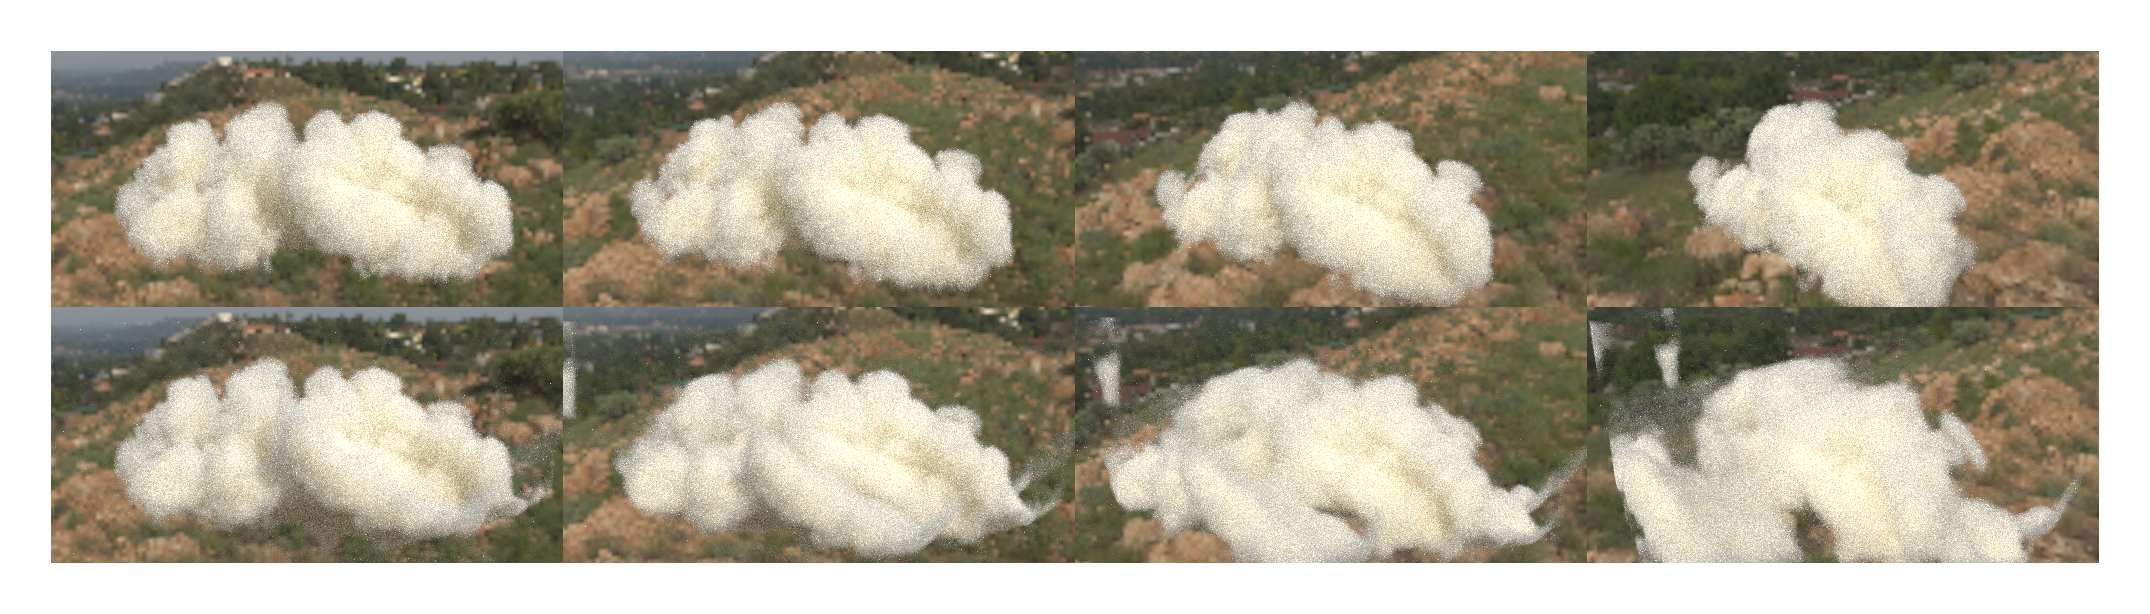

In [5]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# saves the grid in the recorder to be used several times
ref_grid_id = recorder.add_volume(ref_grid)
grid_id = recorder.add_volume(grid)
# saves the environment tensor
env_id = recorder.add_environment(settings['environment'])
# capture multiple camera poses
for i in range(4):
    alpha = (i/4)**1.5
    recorder.new_keyframe(
        # Novel view for the reference grid
        recorder.add_capture_volume(ref_grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms'),
        # Novel view for the sampled grid
        recorder.add_capture_volume(grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms')        
    )
recorder.show_clip(4)

Comparing target view with different lighting conditions...

Rendering captures: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


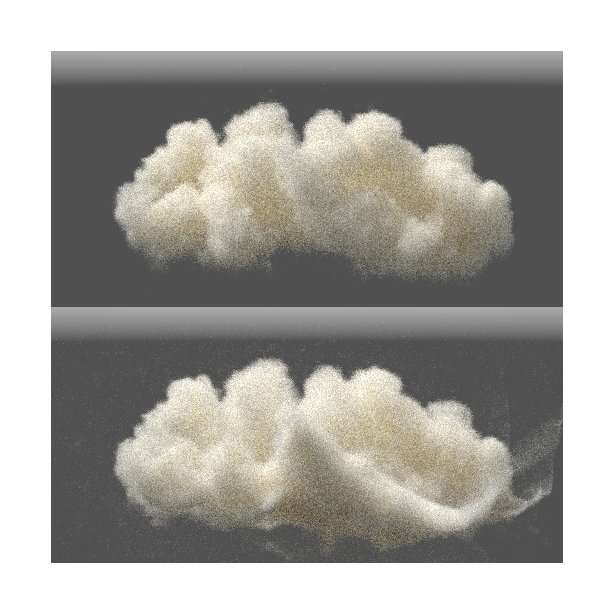

In [6]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# capture multiple camera poses
recorder.new_keyframe(
    # Novel view for the reference grid
    recorder.add_capture_volume(ref_grid,
                                # default environment used
                                camera_position=tuple(settings['camera_positions'][0]),
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms'),
    # Novel view for the sampled grid
    recorder.add_capture_volume(grid,
                                # default environment used
                                camera_position=tuple(settings['camera_positions'][0]),
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms')        
)
recorder.show_clip(1)